In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats
import torch
import os
from tabulate import tabulate
from IPython.display import display, HTML

# Importing Dataset

In [2]:
df = pd.read_csv("../data/processed/trades_2025-10-01_to_2025-10-07_1min.csv")

# Log Normal Poisson Model

In [ ]:
class log_normal_poisson:
    def __init__(self, mean, variance, lag, df: pd.DataFrame):
        if variance < 0:
            raise ValueError("Variance must be positive")
        if lag <= 0:
            raise ValueError("Lag must be positive")
        self.mean = mean
        self.variance = variance
        self.lag = lag
        self.df = df
        self.posterior_means = [math.exp(mean + variance / 2.0)]
        self.ppi = {}

    def generate_posterior_means(self, sample_count=5000, device='cuda'):
        df = self.df.sort_values(by="timestamp").reset_index(drop=True)
        counts = torch.tensor(df["trade_count"].values, dtype=torch.float32, device=device)
        n = len(counts)

        posterior_means = []

        mean = torch.tensor(self.mean, dtype=torch.float32, device=device)
        std = torch.tensor(math.sqrt(self.variance), dtype=torch.float32, device=device)

        for i in range(n):
            means = torch.distributions.LogNormal(mean, std).sample((sample_count,))
            start_idx = max(0, i - self.lag + 1)
            past_counts = counts[start_idx:i]
            if len(past_counts) == 0:
                posterior_means.append(torch.mean(means).item())
                continue

            log_factorial = torch.lgamma(past_counts + 1)
            log_pmf_matrix = past_counts[None, :] * torch.log(means[:, None]) - means[:, None] - log_factorial[None, :]

            log_weights = torch.sum(log_pmf_matrix, dim=1)
            log_weights = log_weights - torch.max(log_weights)
            weights = torch.exp(log_weights)
            weights = weights / torch.sum(weights)

            posterior_mean = torch.sum(weights * means)
            posterior_means.append(posterior_mean.item())

        self.posterior_means = posterior_means

    def generate_ppis(self, percent, sample_count=5000, device='cuda'):
        ppis = {"lower_bound":[], "upper_bound":[]}
        percent = 1 - percent
        df = self.df.sort_values(by="timestamp").reset_index(drop=True)
        counts = torch.tensor(df["trade_count"].values, dtype=torch.float32, device=device)
        n = len(counts)

        mean = torch.tensor(self.mean, dtype=torch.float32, device=device)
        std = torch.tensor(math.sqrt(self.variance), dtype=torch.float32, device=device)

        for i in range(n):
            means = torch.distributions.LogNormal(mean, std).sample((sample_count,))

            start_idx = max(0, i - self.lag + 1)
            past_counts = counts[max(0, i - self.lag + 1):i]

            log_factorial = torch.lgamma(past_counts + 1)
            log_pmf_matrix = past_counts[None, :] * torch.log(means[:, None]) - means[:, None] - log_factorial[None, :]

            log_weights = torch.sum(log_pmf_matrix, dim=1)

            log_weights = log_weights - torch.max(log_weights)
            weights = torch.exp(log_weights)
            weights = weights / torch.sum(weights)

            sample_indices = torch.multinomial(weights, num_samples=sample_count, replacement=True)
            sample_lambdas = means[sample_indices]

            random_samples = torch.poisson(sample_lambdas)

            lower_bound = random_samples.quantile(percent / 2).item()
            upper_bound = random_samples.quantile((1 - percent / 2)).item()
            ppis["lower_bound"].append(lower_bound)
            ppis["upper_bound"].append(upper_bound)



        self.ppi[1 - percent] = ppis

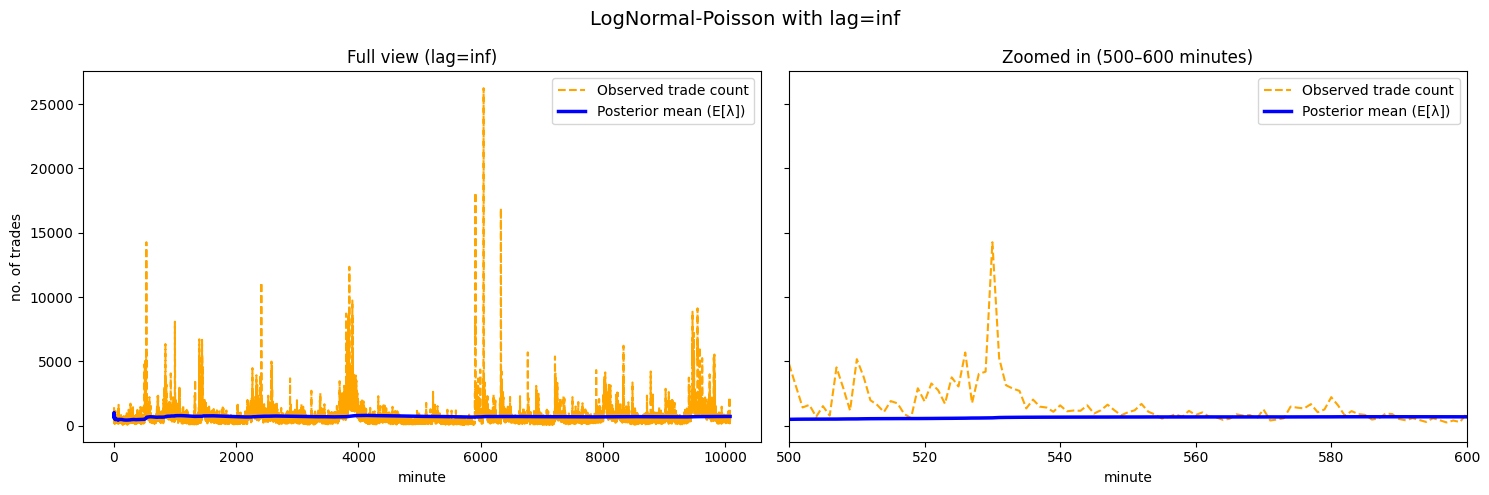

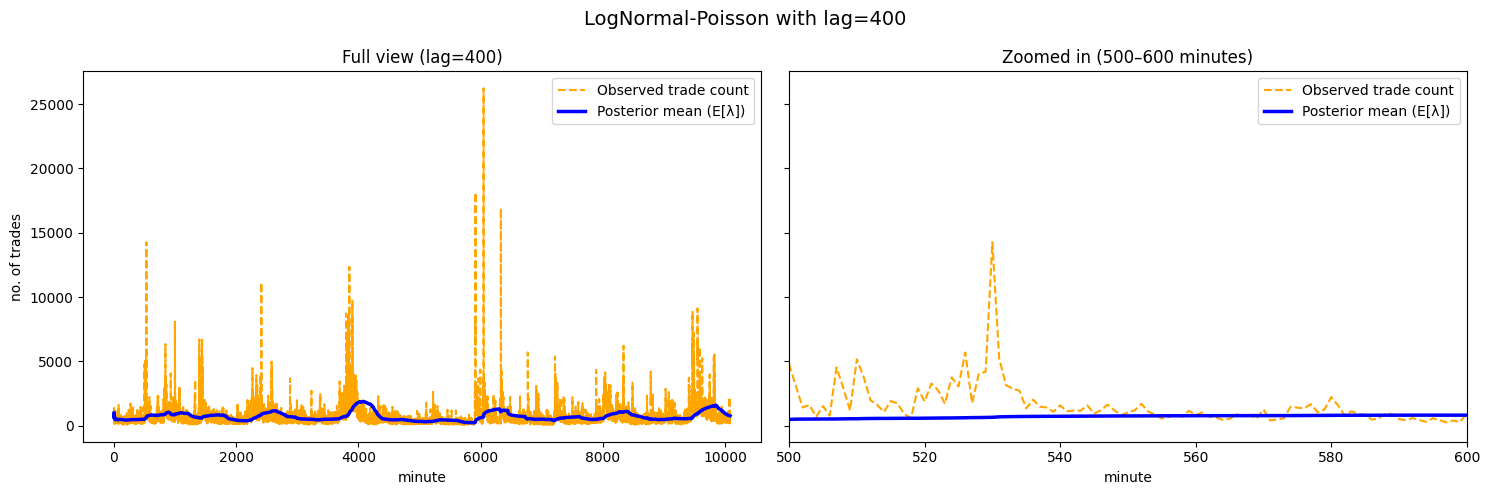

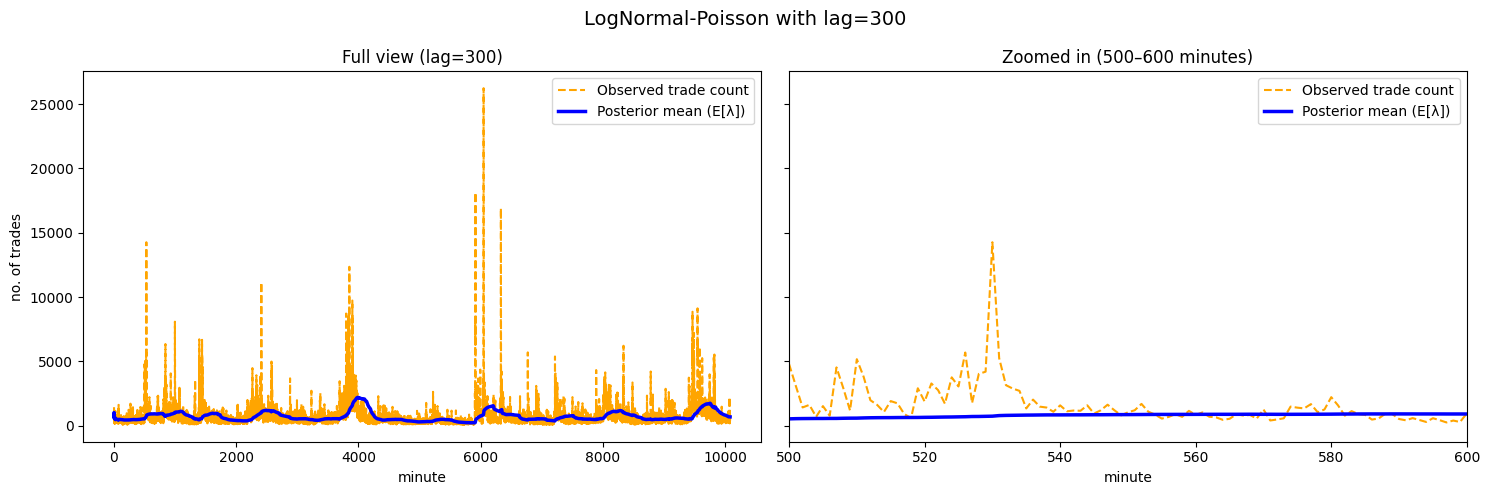

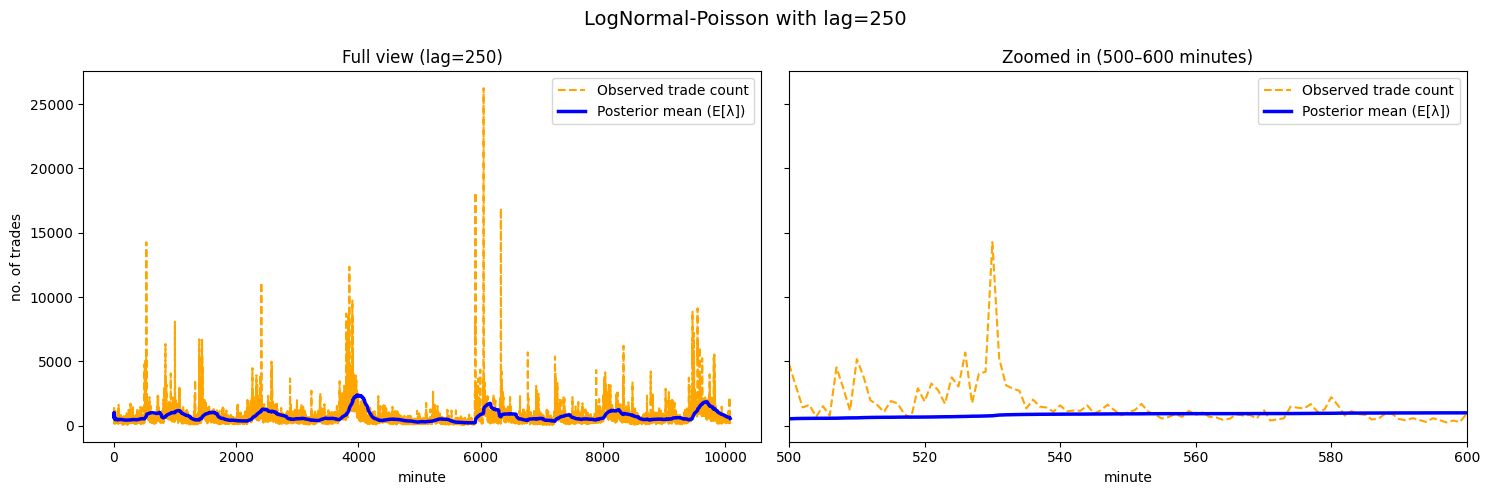

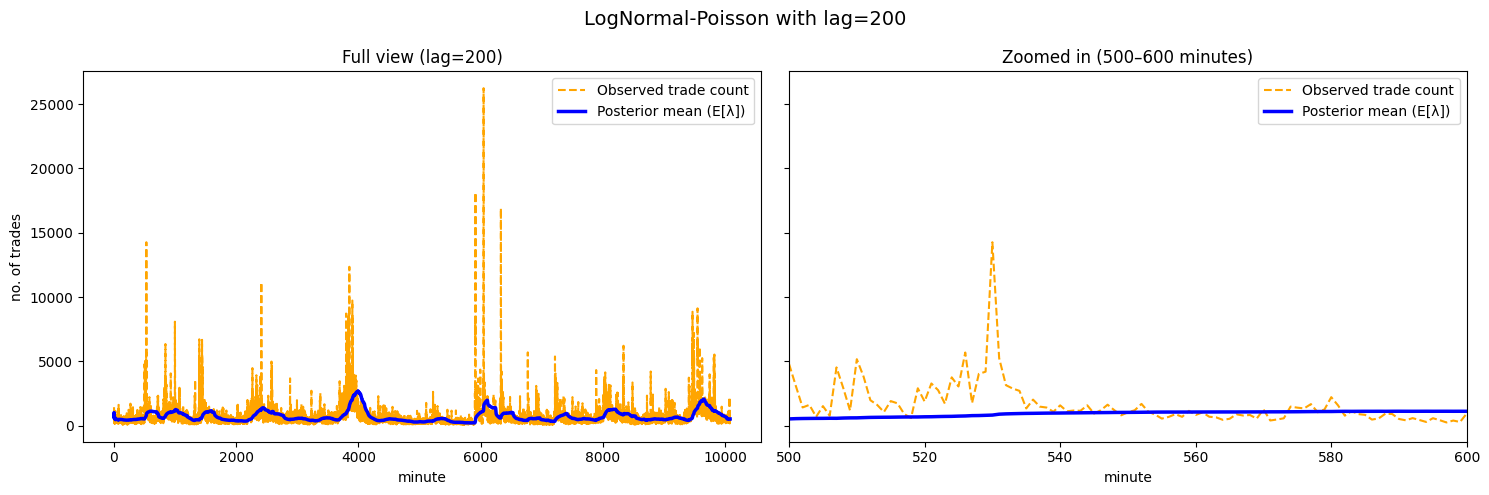

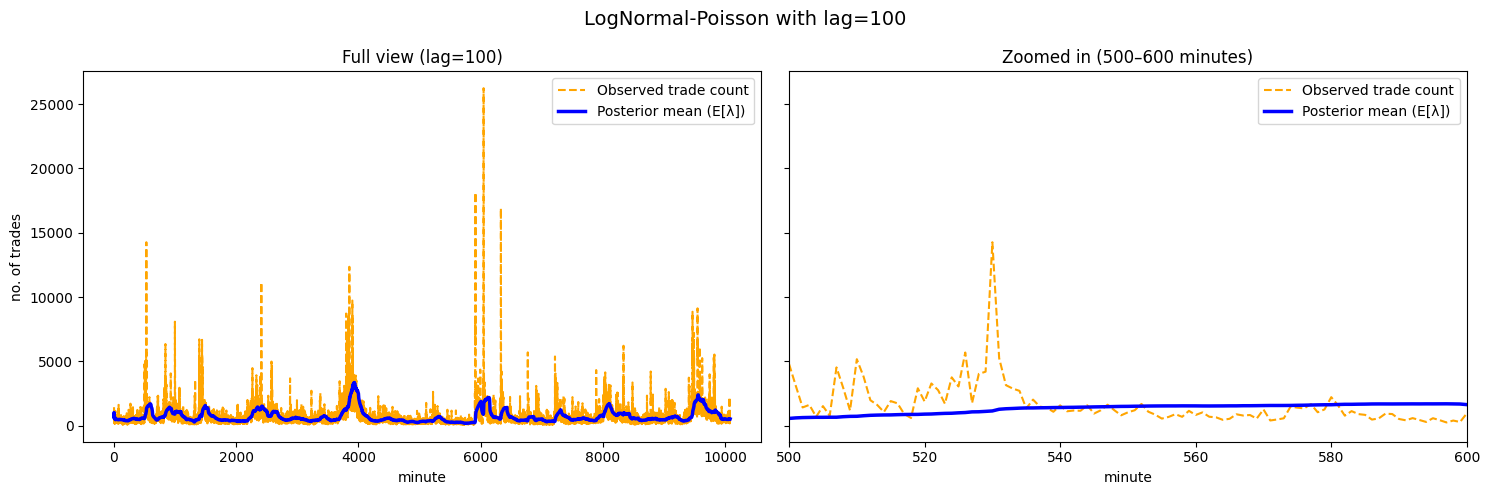

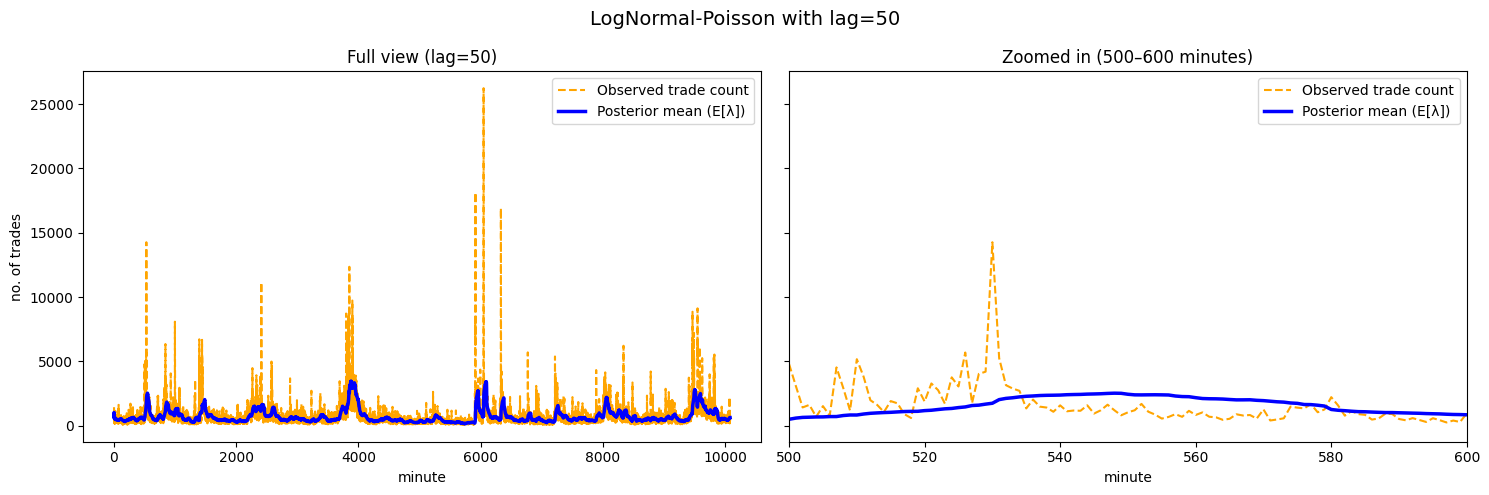

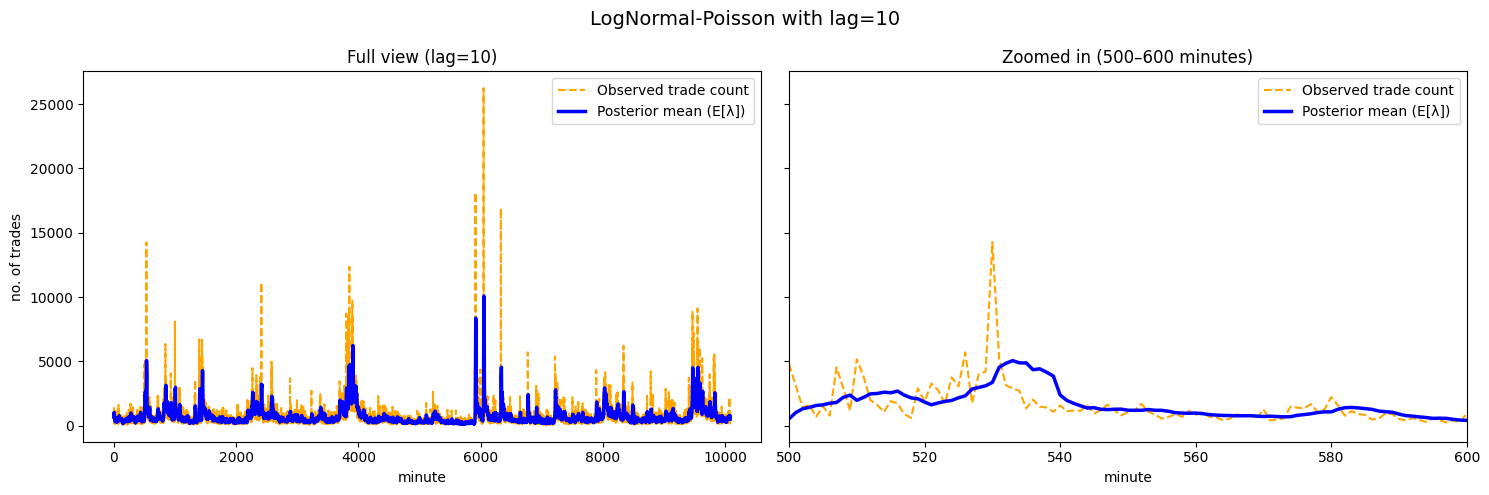

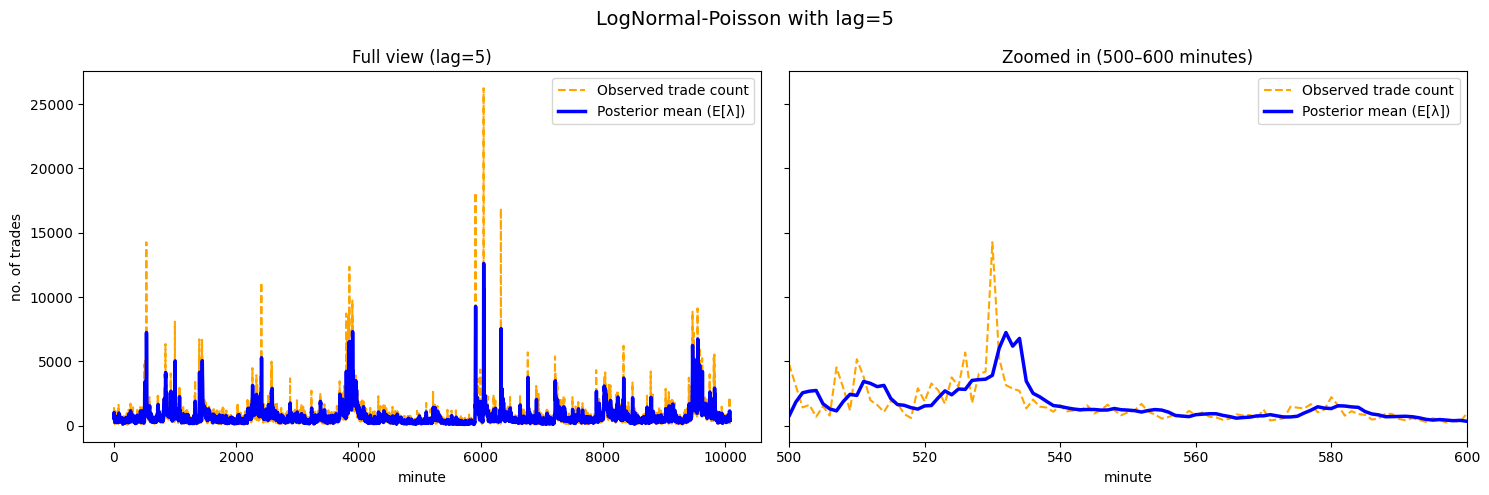

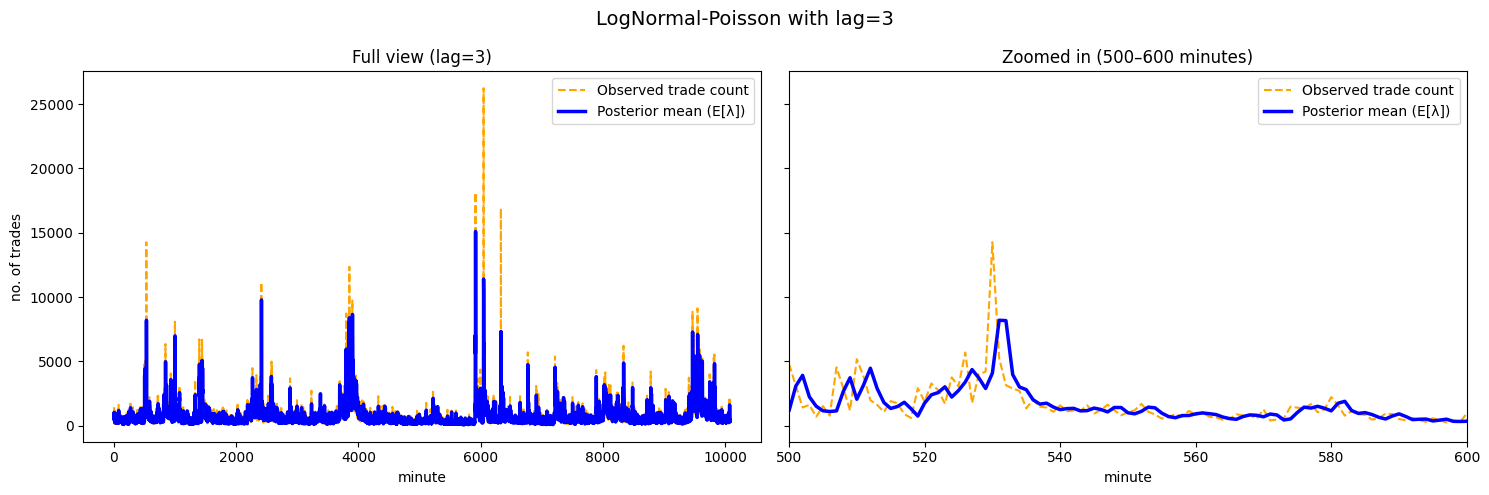

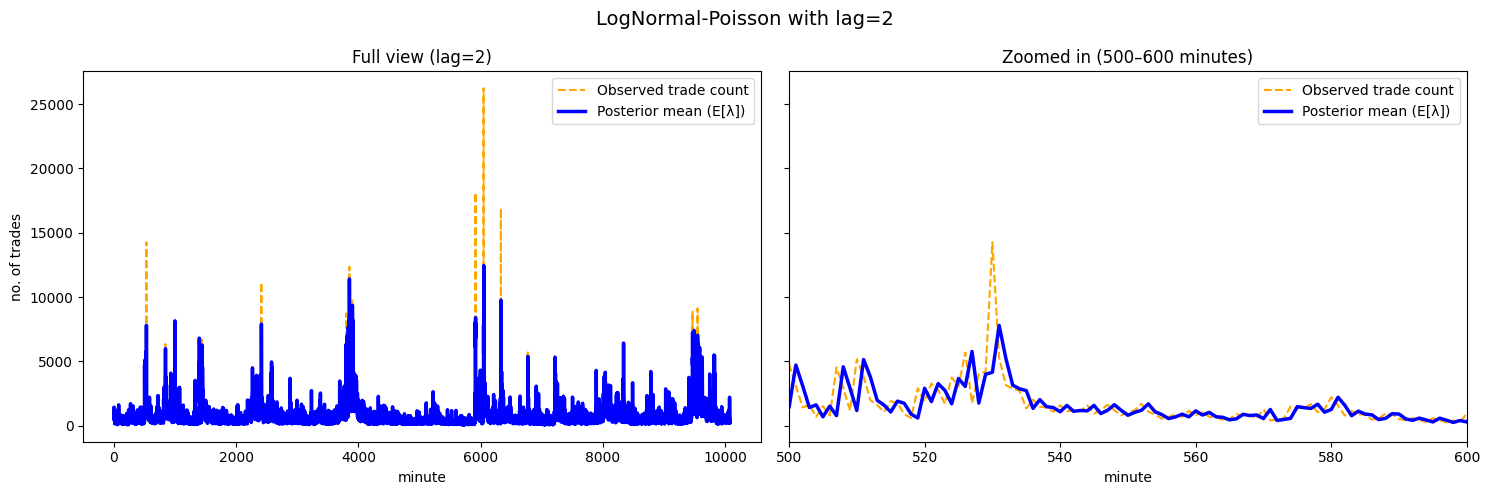

In [ ]:
def expected_lambda(params, lag, zoom_start=0, zoom_end=200):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    lmda = params
    x = range(len(df["trade_count"].values))

    # --- Left: Full plot ---
    axs[0].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    axs[0].plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    axs[0].set_title(f"Full view (lag={lag})")
    axs[0].set_xlabel("minute")
    axs[0].set_ylabel("no. of trades")
    axs[0].legend()

    # --- Right: Zoomed-in plot ---
    axs[1].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    axs[1].plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    axs[1].set_xlim(zoom_start, zoom_end)
    axs[1].set_title(f"Zoomed in ({zoom_start}–{zoom_end} minutes)")
    axs[1].set_xlabel("minute")
    axs[1].legend()

    plt.suptitle(f"LogNormal-Poisson with lag={lag}", fontsize=14)
    plt.tight_layout()
    filename = f"LP_ExpMean_lag_{lag}.png"
    file_path = os.path.join("../figures/", filename) 
    plt.savefig(file_path, format='png')
    plt.show()

for lag in [float('inf'), 400, 300, 250, 200, 100, 50, 10, 5, 3, 2]:
    prior_mean = np.log(df["trade_count"]).mean()
    prior_variance = np.log(df["trade_count"]).var()

    lnp = log_normal_poisson(prior_mean, prior_variance, lag, df)
    lnp.generate_posterior_means()
    expected_lambda(lnp.posterior_means, lag, zoom_start=500, zoom_end=600)

In [ ]:
def check_ppi_validity(model, alpha):
  df = model.df
  df = df.sort_values(by="timestamp").reset_index(drop=True)
  array = df["trade_count"].tolist()
  cnt = 0
  model.generate_ppis(alpha)

  for i in range(len(array)):
    if array[i] < model.ppi[alpha]["lower_bound"][i] or array[i] > model.ppi[alpha]["upper_bound"][i]:
      cnt += 1

  return cnt

table = []
prior_mean = np.log(df["trade_count"]).mean()
prior_variance = np.log(df["trade_count"]).var()
for lag in ([float("inf"), 400, 300, 250, 200, 150, 100, 50, 10, 5, 3, 2]):
    sub = []
    sub.append(lag)
    lnp = log_normal_poisson(prior_mean, prior_variance, lag, df)
    lnp.generate_posterior_means()
    val = check_ppi_validity(lnp, 0.95)
    sub.append(val)
    sub.append(100 * val / len(lnp.df))
    table.append(sub)

html_table = tabulate(table, headers=["Lag", "Count", "Percentage"], tablefmt="html")
display(HTML(html_table))

Lag,Count,Percentage
inf,9369,92.9372
400,9217,91.4294
300,9145,90.7152
250,9120,90.4672
200,9054,89.8125
150,8988,89.1578
100,8967,88.9495
50,8881,88.0964
10,8689,86.1918
5,8515,84.4658
